# Chap11.1 - 심층 신경망 훈련

저번 포스팅 [04. 인공신경망](http://excelsior-cjh.tistory.com/172?category=940400)에서 예제로 살펴본 신경망은 hidden layer가 2개인 얕은 DNN에 대해 다루었다. 하지만, 모델이 복잡해질수록 hidden layer의 개수가 많은 신경망 모델을 학습시켜야 한다. 이러한 깊은 DNN 모델을 학습시키는데에는 다음과 같은 문제가 발생할 확률이 높다.

- **그래디언트 소실**(vanishing gradient) 또는 **폭주**(exploding)가 발생할 수 있다.
- 모델이 복잡하고 커질수록 **학습시간이 매우 느려진다**.
- 모델이 복잡할수록 **오버피팅(overfitting)**될 위험이 크다.

이번 포스팅에서는 이러한 문제들에 대해 알아보고 해결할 수 있는 활성화 함수와 가중치 초기화 방법에 대해  알아보도록 하자.

## 11.1 그래디언트 소실과 폭주 문제

[03. 오차역전파](http://excelsior-cjh.tistory.com/171?category=940400)에서 살펴보았듯이 역전파 알고리즘은 출력층(output layer)에서 입력층(input layer)로 오차 그래디언트(gradient)를 흘려 보내면서 각 뉴런의 입력값에 대한 손실함수의 그래디언트를 계산한다. 이렇게 계산된 그래디언트를 경사 하강법(gradient descent)단계에서 각 가중치 매개변수($\mathbf{W}$)를 업데이트 해준다. 

하지만, 아래의 그림과 같이 깊이가 깊은 심층신경망에서는 역전파 알고리즘이 입력층으로 전달됨에 따라 그래디언트가 점점 작아져 결국 가중치 매개변수가 업데이트 되지 않는 경우가 발생하게 된다. 이러한 문제를 **그래디언트 소실**(vanishing gradient)라고 한다. 

![](./images/vanishing.png)

그래디언트 소실과는 반대로 역전파에서 그래디언트가 점점 커져 입력층으로 갈수록 가중치 매개변수가 기하급수적으로 커지게 되는 경우가 있는데 이를 **그래디언트 폭주**(exploding gradient)라고 하며, 이 경우에는 발산(diverse)하게되어 학습이 제대로 이루어지지 않는다. 

## 11.2 활성화 함수

[04. 인공신경망 - 2.4.1](http://excelsior-cjh.tistory.com/172?category=940400)에서 활성화 여러 종류의 활성화 함수에 대해 알아 보았듯이, 아래의 그림(출처: cs231n)에서 함수 $f$와 같이 입력 신호의 총합($\sum_{i}^{}{w_ix_i + b}$)을 출력 신호로 변환하는 함수를 **활성화 함수**(activation function)라고 한다.

![](./images/activations.png)


### 11.2.1 시그모이드 함수

시그모이드 함수($\sigma$, sigmoid)는 대표적인 활성화 함수라고 할 수 있으며, 아래와 같은 식을 가지는 함수이다.
$$
\sigma(x) = \frac{1}{1+e^{-x}}
$$
시그모이드 함수는 다음과 같은 특성을 가진다.

- 입력 신호의 총합을 0에서 1사이의 값으로 바꿔준다.
- 입력 신호의 값이 커질수록(작아질수록) 뉴런의 활성화률(firing rate)이 $1$(작아질 경우 $0$)로 수렴(saturation)한다.

![](./images/sigmoid2.png)



하지만, 위와 같은 특성 때문에 시그모이드 함수는 2가지 문제가 있다.

- 입력의 절대값이 크게 되면 0이나 1로 수렴하게 되는데, 이러한 뉴런들은 **그래디언트를 소멸(kill) 시켜 버린다**. 그 이유는 수렴된 뉴런의 그래디언트 값은 0이기 때문에 역전파에서 0이 곱해지기 때문이다. 따라서, 역전파가 진행됨에 따라 아래 층(layer)에는 아무것도 전달되지 않는다.(시그모이드의 도함수는 $\sigma(1- \sigma)$이므로 함수의 값이 0이나 1에 가까우면 도함수의 결과가 매우 작아진다.)
- **원점 중심이 아니다(Not zero-centered)**.  따라서, 평균이 $0$이 아니라 $0.5$이며, 시그모이드 함수는 항상 양수를 출력하기 때문에 출력의 가중치 합이 입력의 가중치 합보다 커질 가능성이 높다. 이것을 편향 이동(bias shift)이라 하며, 이러한 이유로 **각 레이어를 지날 때마다 분산이 계속 커져** 가장 높은 레이어에서는 활성화 함수의 출력이 0이나 1로 수렴하게 되어 그래디언트 소실 문제가 일어나게 된다.

### 11.2.2 하이퍼볼릭 탄젠트 함수(tanh)

하이퍼볼릭 탄젠트 함수(tanh, hyperbolic tangent)는 시그모이드 함수의 대체제로 사용할 수 있는 활성화 함수이며 아래와 같은 식을 갖는 함수이다.
$$
\begin{align*}
\text{tanh}(x) &= \frac{1-e^{-x}}{1+e^{-x}} \\ &= \frac{2}{1+e^{-2x}} -1
\end{align*}
$$
tanh함수는 시그모이드 함수($\sigma$)와 유사하며, 아래와 같이 시그모이드 함수를 이용해 tanh 함수를 나타낼 수 있다.

$$
\text{tanh}(x) = 2 \sigma(2x)-1
$$
tanh함수는 아래의 그림과 같이 입력값의 총합을 -1에서 1사이의 값으로 변환해 주며, 원점 중심(zero-centered)이기 때문에, 시그모이드와 달리 편향 이동이 일어나지 않는다. 하지만, tanh함수 또한 입력의 절대값이 클 경우 -1이나 1로 수렴하게 되므로 그래디언트를 소멸시켜 버리는 문제가 있다. 

![](./images/tanh.png)

### 11.2.3 ReLU (Rectified Linear Unit)

ReLU(렐루, Rectified Linear Unit)는 시그모이드 계열과는 다른 활성화 함수이며,  아래의 식과 같이 입력이 0이상이면 입력을 그대로 출력하고, 0 이하이면 0을 출력하는 함수이다.
$$
\text{ReLU}(x) = \max(0, x)
$$
ReLU함수는 다음과 같은 특성을 가진다.

- 0 이상인 곳에서는 수렴하는 구간이 없다.
- 단순히 입력값을 그대로 출력으로 내보내기 때문에 시그모이드 함수에 비해 계산 속도가 빠르다.
- sigmoid/tanh에 비해 stochastic gradient descent(SGD)에서 수렴속도가 무려 6배나 빠르다고 한다([Krizhevsky et al.](http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf)).

![](./images/relu.PNG)

## 11.3 수렴하지 않는 활성화 함수

2.3 에서 살펴본 ReLU함수 또한 완벽하지 않다. ReLU의 문제는 모델이 학습하는 동안 **일부 뉴런이 0만을 출력하여 활성화 되지 않는 문제**인데, 이러한 문제를 **dead ReLU**라고 한다. 특히 학습률(learning rate)이 클 경우, 모델의 뉴런이 절반정도가 죽어 있기도(뉴런이 0만 출력) 한다. 이렇게 뉴런이 0만을 출력하는 이유는 학습이 진행되면서 뉴런의 **가중치가 업데이트 되면서 가중치 합이 음수가 되는 순간** ReLU에 의해 그 이후로는 0만 출력하게 되며, 이때의 그래디언트 값이 0이 되기 때문이다.

이러한 **dead ReLU**문제를 해결하기 위해 ReLU함수를 조금씩 변형시켜 다양한 ReLU Family를 만들어 사용하기도 한다. 대표적인 ReLU Family를 알아보도록 하자.

### 11.3.1 LeakyReLU & PReLU

LeakyReLU는 다음과 같은 식을 가지는 ReLU의 변형된 함수이다.
$$
\text{LeakyReLU}_{\alpha}(x) = \max(\alpha x, x)
$$
위의 식에서 하이퍼파라미터인 $\alpha$가 LeakyReLU함수의 새는(leaky, 기울기)정도를 결정하며, 일반적으로 $\alpha = 0.01$로 설정한다. 즉, 0 이하인 입력에 대해 활성화 함수가 0만을 출력하기 보다는 입력값에 $\alpha$만큼 곱해진 값을 출력으로 내보내어 dead ReLU문제를 해결한다.

![](./images/leaky.PNG)



PReLU(Parametric ReLU)는 Leaky ReLU와 식이 동일하지만, LeakyReLU에서 하이퍼파라미터인 $\alpha$를 가중치 매개변수와 마찬가지로 $\alpha$의 값도 학습되도록 역전파에 의해 $\alpha$의 값이 변경되는 함수이다. PReLU는 대규모 이미지 데이터셋에서는 ReLU보다 성능이 좋았지만, 소규모 데이터셋에는 오버피팅될 위험이 있다.


### 11.3.2 ELU (Exponential Linear Unit)

ELU(Exponential Linear Unit)은 2105년 [B.Xu et al.](https://arxiv.org/pdf/1507289v5.pdf)의 논문에서 제안된 활성화 함수이다. 
$$
\text{ELU}_{\alpha} = \begin{cases} \alpha \left( \exp{(x)} - 1 \right) & \text{if }x <0 \\ x & \text{if } x \ge 0 \end{cases}
$$


![](./images/elu.PNG)



ELU는 ReLU와 달리 다음과 같은 특성을 가진다.

- $x < 0$일 때 ELU 활성화 함수 출력의 평균이 0(zero mean)에 가까워지기 때문에 편향 이동(bias shift)이 감소하여 그래디언트 소실 문제를 줄여준다. 하이퍼파라미터인 $\alpha$는 $x$가 음수일 때 ELU가 수렴할 값을 정의하며 보통 1로 설정한다.
- $x < 0$ 이어도 그래디언티가 0이 아니므로 죽은(dead) 뉴런을 만들지 않는다. 
- $\alpha = 1$일 때 ELU는 $x=0$에서 급격하게 변하지 않고 모든 구간에서 매끄럽게 변하기 때문에 경사하강법에서 수렴속도가 빠르다.



> **TLDR** : *어떠한 활성화 함수를 써야할까?*
>
> 일반적으로 ELU → LeakyReLU → ReLU → tanh → sigmoid 순으로 사용한다고 한다. cs231n 강의에서는 ReLU를 먼저 쓰고 , 그다음으로 LeakyReLU나 ELU 같은 ReLU Family를 쓰며, sigmoid는 사용하지 말라고 하고 있다.

## 11.4 가중치 초기화 (Weight Initialization)

신경망 학습에서 중요한것 중 하나는 학습 시킬 때의 가중치 초기값이다. 가중치 초기값을 어떻게 초기화 하느냐에 따라 학습이 잘될 때가 있고 잘 안될 때가 있다.  이번에는 가중치를 초기화하는 방법에 대해 알아보도록 하자.

### 11.4.1 가중치 초기값이 0이거나 동일한 경우

가중치의 초기값을 모두 0으로 초기화하거나 동일한 값으로 초기화할 경우 모든 뉴런의 동일한 출력값을 내보낼 것이다.  그렇게 되면 역전파(backpropaation) 단계에서 각 뉴런이 모두 동일한 그래디언트 값을 가지게 된다. 학습이 잘 되려면, 각 뉴런이 가중치에 따라 비대칭(asymmetry, 어떤 뉴런은 가중치가 크고 어떤 뉴런은 가중치가 작게 되게끔)이어야 하는데, 모든 뉴런이 동일한 그래디언트로 가중치 값이 변경되므로 뉴런의 개수가 아무리 많아도 뉴런이 하나뿐인 것처럼 작동하기 때문에 학습이 제대로 이루어지지 않는다.  따라서 가중치 초기값을 동일한 값으로 초기화 해서는 안된다.

### 11.4.2 작은 난수 (Small Random numbers) 인 경우 

가중치 초기값은 작은 값으로 초기화 해야하는 데, 그 이유는 활성화 함수가 sigmoid일 경우 만약 가중치 초기값(절대값)을 큰 값으로 한다면 0과 1로 수렴하기 때문에 그래디언트 소실이 발생하게 된다. 또한 활성화 함수가 ReLU일 경우 절대값이 클 경우 음수일 때는 dead ReLU 문제가 발생하고, 양수일 때는 그래디언트 폭주가 일어나게 된다. 

따라서, 가중치 초기값을 작게 초기화 해야하며 동일한 초기값을 가지지 않도록 랜덤하게 초기화 해야한다. 일반적으로 가중치 초기값은 평균이 0이고 표준편차가 0.01인 정규분포(가우시안 분포)를 따르는 값으로 랜덤하게 초기화 한다.

이러한 가중치 초기화 방법은 얕은 신경망에서는 괜찮게 작동할지 모르지만 신경망의 깊이가 깊어질수록 문제가 발생하게 된다. 예를들어, 평균이 0이고 표준편차가 0.01인 정규분포(가우시안 분포)를 따르는 값으로 랜덤하게 초기화하고 tanh를 활성화 함수로 사용하였을 경우, 아래의 그림처럼 첫번째 hidden layer를 제외한 나머지 레이어들이 모두 0을 출력하고 있는것을 확인할 수 있다. 따라서, 11.4.1에서 살펴보았듯이 모든 뉴런의 그래디언트 값이 동일하기 때문에 학습이 이루어지지 않게 된다. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# https://github.com/WegraLee/deep-learning-from-scratch/blob/master/ch06/weight_init_activation_histogram.py

# sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# ReLU
def ReLU(x):
    return np.maximum(0, x)

# tanh
def tanh(x):
    return np.tanh(x)

def weight_init(method=None):
    '''가중치 초기화 함수
    
    Args:
        - method: 가중치 초기화 방법(large, small, xavier, relu)
    Returns:
        - np.array형태의 가중치 초기값
    '''
    w = 0
    if method == 'large':
        w = np.random.randn(node_num, node_num) * 1
    elif method == 'small':
        w = np.random.randn(node_num, node_num) * 0.01
    elif method == 'xavier':
        w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)  # Xavier init
    elif method == 'he':
        w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)  # He init
    
    return w

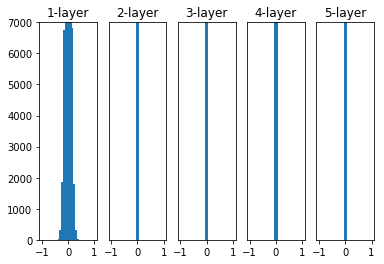

In [26]:
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = weight_init('small')
    a = np.dot(x, w)

    # z = sigmoid(a)
    # z = ReLU(a)
    z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
#     plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(-1,1))
plt.show()

또한, 평균이 0이고 표준편차가 1인 정규분포를 따르는 값으로 랜덤하게 초기화하고 tanh를 활성화 함수로 사용하였을 경우에는 아래의 그림처럼 tanh의 출력이 -1과 1로 집중되면서 그래디언트 소실(vanishing gradient) 문제가 발생하게 된다.

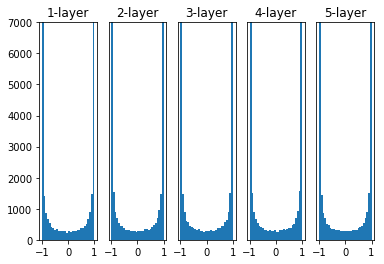

In [27]:
for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = weight_init('large')
    a = np.dot(x, w)

    # z = sigmoid(a)
    # z = ReLU(a)
    z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
#     plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(-1,1))
plt.show()

따라서, 작은 난수로 가중치를 초기화 하는 방법 또한 심층 신경망(DNN)에서는 적합하지 않다고 할 수 있다.

### 11.4.3 Xavier 초기화와 He 초기화

학습이 제대로 이루어지기 위해서는 각 뉴런의 활성화 함수 출력값이 고르게 분포되어 있어야 한다. 레이어와 레이어 사이에 다양한 데이터가 흘러야(forward, backprop) 신경망 학습이 효율적으로 이루어진다. 만약, 4.2에서와 같이 한쪽으로 치우친 데이터가 흐르게 되면 그래디언트 소실이나 모든 뉴런의 그래디언트 값이 동일해져 학습이 이루어지지 않는 문제가 발생한다.

#### 11.4.3.1 Xavier Initialization

[Xavier Glorot과 Yoshua Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)는 적절한 데이터가 흐르기 위해서는 각 레이어의 출력에 대한 분산이 입력에 대한 분산과 같아야 하며, 역전파에서 레이어를 통과하기 전과 후의 그래디언트 분산이 동일해야 한다고 주장했다.  Glorot과 Bengio는 'Understanding the Difficulty of Training Deep Feedforward Neural Networks'라는 논문에서 아래의 식과 같은 가중치 초기값을 제안했는 데, 이러한 초기화 방법을 **Xavier Initialization** 라고 한다.

Xavier 초기값은 **활성화 함수가 선형(linear)이라고 가정**한다. 아래의 그림에서 처럼 sigmoid 계열(sigmoid, tanh)의 활성화 함수는 좌우 대칭이며 가운데 부분이 선형인 함수로 볼 수 있다.

![](./images/sigmoid-linear.png)



이러한 가정을 토대로 sigmoid 활성화 함수에서의 Xavier initialization 식은 다음과 같다.

- 평균이 0이고 표준편차 $\sigma = \sqrt{\frac{2}{n_{\text{inputs}} + n_{\text{outputs}}}}$ 인 정규분포
- 또는 $r = \sqrt{\frac{6}{n_{\text{inputs}} + n_{\text{outputs}}}}$ 일 때 $-r$과 $+r$ 사이의 균등분포
- 입력의 연결 개수와 출력의 연결 개수가 비슷할 경우 $\sigma = 1/\sqrt{n_{\text{inputs}}}$ 또는 $r = \sqrt{3} / \sqrt{n_{\text{inputs}}}$ 를 사용

아래의 그림처럼 tanh 활성화 함수에 xavier 초기값을 설정했을 때, 4.2에서 작은 난수 초기화 했을 때보다 넓게 분포되어 있는것을 확인할 수 있다.

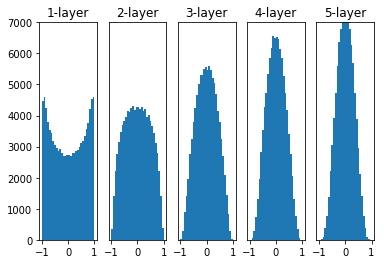

In [35]:
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = weight_init('xavier')
    a = np.dot(x, w)

    # z = sigmoid(a)
    # z = ReLU(a)
    z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
#     plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(-1,1))
plt.show()

텐서플로에서는 이러한 Xavier 초기값을 쉽게 사용할 수 있도록 [`tf.contrib.xavier_initializer`](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/xavier_initializer)를 제공한다.

#### 11.4.3.2 He Initialization 

하지만, Xavier 초기값은 ReLU 활성화 함수에서는 아래의 그림처럼 레이어가 깊어질 수록 출력값이 0으로 치우치는 문제가 발생한다.

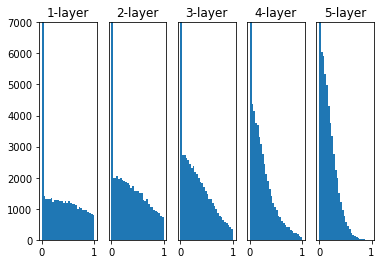

In [34]:
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = weight_init('xavier')
    a = np.dot(x, w)

    # z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
#     plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

Kaiming He는 'Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classifcation' 논문에서 ReLU에 적합한 초기값을 제안했는 데, 이를 그의 이름을 따 **He 초기값**이라고 하며 다음과 같은 식이다.

- 평균이 0이고 표준편차 $\sigma = \sqrt{2} \cdot \sqrt{\frac{2}{n_{\text{inputs}} + n_{\text{outputs}}}}$인 정규분포
- 또는 $r = \sqrt{2} \cdot \sqrt{\frac{6}{n_{\text{inputs}} + n_{\text{outputs}}}}$ 일 때 $-r$과 $+r$ 사이의 균등분포
- 입력의 연결 개수와 출력의 연결 개수가 비슷할 경우 $\sigma = \sqrt{2}/\sqrt{n_{\text{inputs}}}$ 또는 $r = \sqrt{2} \cdot \sqrt{3} / \sqrt{n_{\text{inputs}}}$ 를 사용

위의 식에서 알 수있듯이, He 초기값은 Xavier 초기값에서 $\sqrt{2}$ 배 해줬다는 것을 확인할 수 있다. 그 이유는 ReLU는 입력이 음수일 때 출력이 전부 0이기 때문에 더 넓게 분포시키기 위해서이다.

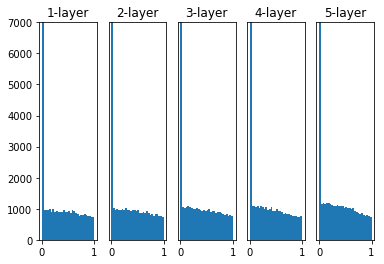

In [33]:
input_data = np.random.randn(1000, 100)  # 1000개의 데이터
node_num = 100  # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5  # 은닉층이 5개
activations = {}  # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = weight_init('he')
    a = np.dot(x, w)

    # z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
#     plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

He 초기값 또한 텐서플로에서 쉽게 사용할 수 있도록 [`tf.keras.initializers.he_normal`](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/he_normal) 과 [`tf.keras.initializers.he_uniform`](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/he_uniform)을 제공한다.

## 5. 마무리 

이번 포스팅에서는 심층 신경망을 학습시키기 위해 적절한 활성화 함수와 가중치 초기화 방법에 대해 알아보았다.  이번 포스팅의 내용을 아주 간략하게 요약하면 다음과 같다.

- 활성화 함수로는 ReLU를 먼저 사용하는 것이 좋다.
- 가중치 초기화는 Sigmoid일 경우 Xavier, ReLU일 경우 He 초기값을 사용하는 것이 좋다.